# 数据处理

In [ ]:
# 读取与基础清洗
import pandas as pd
import numpy as np
df = pd.read_excel(r'基差//TL基差.xls', dtype=str)  # 先按字符串读入，便于统一清洗
if '日期' in df.columns:
    df['日期'] = pd.to_datetime(df['日期'], errors='coerce')
    df = df.sort_values('日期').set_index('日期')
else:
    raise ValueError("未找到‘日期’列")

# 列名去空格
df.columns = df.columns.str.strip()

# 将可能带 %、逗号、全角空格 的列转成纯数字
def to_numeric_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace('\u3000', '', regex=False).str.strip()       # 去全角空格
    s = s.str.replace(',', '', regex=False)                                    # 去千分位逗号
    # 处理百分号：若该列有大量 %，按百分数解析
    if (s.str.contains('%')).mean() > 0.3:                                     # 阈值可调
        s = s.str.replace('%', '', regex=False)
        return pd.to_numeric(s, errors='coerce') / 100.0
    return pd.to_numeric(s, errors='coerce')

for c in df.columns:
    df[c] = to_numeric_series(df[c])

# 只对数值列做差分（防止非数值列参与运算）
num_cols = df.select_dtypes(include=[np.number]).columns
df_diff = df[num_cols].diff(1)

# 丢首行缺失
df_clean = df_diff.dropna().copy()

# 标签：下一期 Δ(基差) 是否 > 0   —— 确保列名匹配你文件中的“基差”列
basis_col = None
for c in df_clean.columns:
    if '基差' in str(c):
        basis_col = c; break
if basis_col is None:
    raise ValueError("未在数据中找到包含‘基差’的列名，请确认列名。")

df_clean['value_sort'] = df_clean[basis_col].shift(-1).apply(lambda x: 1 if x > 0 else 0)
df_clean = df_clean.iloc[:-1]


In [3]:
print(df_clean['value_sort'].value_counts())

value_sort
0    1387
1    1324
Name: count, dtype: int64


In [5]:
df_clean.head()

,收益率(%),净价,全价,期货价格,发票价格,转换因子,基差,期现价差,IRR(%),十债主连成交量,十债主连持仓量,置信区间上限,置信区间下限,value_sort
日期,,,,,,,,,,,,,,
2015-03-23,0.0474,-1.6347,-2.0209,-0.090,-2.0714,-0.0161,0.0247,-0.1054,-0.0274,-1946.0,865.0,0.0371,-0.0124,1
2015-03-24,-0.0616,1.7541,2.1857,-0.050,1.9185,0.0161,0.2476,-0.2123,-0.4812,-6.0,420.0,0.3078,-0.1345,0
2015-03-25,0.0712,-1.8321,-2.2418,-0.070,-2.0476,-0.0161,-0.1965,0.1392,0.4006,-146.0,382.0,-0.0378,0.0262,1
2015-03-26,0.0545,-0.4341,-0.4231,-0.420,-0.4521,0.0000,0.0180,-0.0290,-0.0046,-161.0,530.0,-0.0225,0.0227,0
2015-03-27,0.0129,-0.1031,-0.0921,-0.045,-0.0484,0.0000,-0.0547,0.0437,0.1271,719.0,563.0,-0.0053,0.0210,1


# LIGHTGBM

In [18]:
# ========= 全量可运行脚本：漂移检查 + 阈值策略 + 贝叶斯超参搜索
# （XGBoost 原生API版，兼容老版本；支持“可切换评优指标 + 可配置阈值来源”）=========
# 依赖：
#   pip install numpy pandas scipy scikit-learn xgboost optuna
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd

from scipy.stats import ks_2samp, chi2_contingency
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, log_loss
)
import xgboost as xgb
import optuna

# ========= 公共工具 =========

def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

def safe_auc(y_true, y_prob):
    y_true = np.asarray(y_true).astype(int)
    if len(np.unique(y_true)) < 2:
        return np.nan
    return roc_auc_score(y_true, y_prob)

# ========= 0) XGBoost 原生训练/预测封装（适配所有版本） =========

def _pack_xgb_params(params):
    """
    将 Optuna/外部给的 sklearn 风格参数映射为 xgb.train 可用字典。
    """
    p = dict(params) if params else {}
    # 通用默认
    p.setdefault("objective", "binary:logistic")
    p.setdefault("eval_metric", "auc")
    # 学习率名称差异
    if "learning_rate" in p:
        p["eta"] = p.pop("learning_rate")
    # n_estimators 在 train 里用 num_boost_round 传，不放进 params
    p.pop("n_estimators", None)
    # 一些 sklearn 专属键删除
    for k in ["verbosity", "n_jobs", "random_state"]:
        p.pop(k, None)
    # 返回 xgb.train 用的参数
    return p

def train_xgb_booster(
    X_tr, y_tr, X_val, y_val,
    params,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose=False
):
    """
    用 xgb.train 训练，支持早停。返回 booster 对象。
    """
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    watchlist = [(dtrain, "train"), (dvalid, "valid")]
    xgb_params = _pack_xgb_params(params)

    booster = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=bool(verbose)
    )
    return booster

def predict_proba_booster(booster, X):
    """
    兼容不同 XGBoost 版本：优先使用 best_iteration / best_ntree_limit。
    返回正类概率（shape: [n_samples]）。
    """
    dtest = xgb.DMatrix(X)
    # 新版本：有 best_iteration
    best_iteration = getattr(booster, "best_iteration", None)
    if best_iteration is not None:
        # iteration_range 是新API；老版本不支持就走下面 ntree_limit
        try:
            return booster.predict(dtest, iteration_range=(0, best_iteration + 1))
        except TypeError:
            pass
    # 较老版本：best_ntree_limit
    best_ntree_limit = getattr(booster, "best_ntree_limit", None)
    if best_ntree_limit is not None:
        try:
            return booster.predict(dtest, ntree_limit=best_ntree_limit)
        except TypeError:
            pass
    # 最保守：不指定限制
    return booster.predict(dtest)

# ========= 1) 特征稳定性 / 漂移检查 =========

def psi_for_series(train_s: pd.Series, test_s: pd.Series, bins=10):
    """Population Stability Index (PSI) for continuous variables. 使用训练分位数分箱"""
    train_s = pd.to_numeric(train_s, errors='coerce')
    test_s  = pd.to_numeric(test_s,  errors='coerce')
    tr = train_s.dropna(); te = test_s.dropna()
    if tr.empty or te.empty:
        return np.nan
    quantiles = np.linspace(0, 1, bins + 1)
    cuts = np.unique(np.nanquantile(tr, quantiles))
    if len(cuts) <= 2:
        return np.nan
    tr_bins = pd.cut(train_s, bins=cuts, include_lowest=True)
    te_bins = pd.cut(test_s,  bins=cuts, include_lowest=True)
    tr_ratio = tr_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_bins.value_counts(normalize=True).sort_index()
    te_ratio = te_ratio.reindex(tr_ratio.index).fillna(0.0)
    tr_ratio = tr_ratio.fillna(0.0)
    tr_ratio = tr_ratio.replace(0, 1e-8)
    te_ratio = te_ratio.replace(0, 1e-8)
    psi = np.sum((te_ratio - tr_ratio) * np.log(te_ratio / tr_ratio))
    return float(psi)

def cat_psi(train_s: pd.Series, test_s: pd.Series):
    """PSI for categorical distributions."""
    tr_p = train_s.value_counts(normalize=True)
    te_p = test_s.value_counts(normalize=True)
    idx = tr_p.index.union(te_p.index)
    tr_p = tr_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    te_p = te_p.reindex(idx).fillna(0.0).replace(0, 1e-8)
    psi = np.sum((te_p - tr_p) * np.log(te_p / tr_p))
    return float(psi)

def two_sample_drift(train_s: pd.Series, test_s: pd.Series, is_categorical=False):
    """连续：两样本KS；类别：卡方独立性（p越小漂移越显著）"""
    if is_categorical:
        idx = pd.Index(pd.concat([train_s.astype(str), test_s.astype(str)], ignore_index=True).unique())
        tr_counts = train_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        te_counts = test_s.astype(str).value_counts().reindex(idx, fill_value=0).astype(float)
        table = np.vstack([tr_counts.values, te_counts.values])
        try:
            chi2, p, dof, exp = chi2_contingency(table)
        except ValueError:
            p = 1.0
        return {"stat": None, "pvalue": float(p)}
    else:
        tr = pd.to_numeric(train_s, errors='coerce').dropna()
        te = pd.to_numeric(test_s,  errors='coerce').dropna()
        if len(tr) < 2 or len(te) < 2:
            return {"stat": None, "pvalue": np.nan}
        ks = ks_2samp(tr, te, alternative='two-sided', mode='auto')
        return {"stat": float(ks.statistic), "pvalue": float(ks.pvalue)}

def drift_report(df_ref: pd.DataFrame, df_new: pd.DataFrame,
                 categorical_cols=None, topk=15):
    """生成漂移报告（相对 df_ref）"""
    categorical_cols = set(categorical_cols or [])
    rows = []
    for c in df_ref.columns:
        is_cat = c in categorical_cols or (df_ref[c].dtype.name in ["category", "object"])
        psi = cat_psi(df_ref[c], df_new[c]) if is_cat else psi_for_series(df_ref[c], df_new[c])
        stat = two_sample_drift(df_ref[c], df_new[c], is_categorical=is_cat)
        miss_ref = df_ref[c].isna().mean()
        miss_new = df_new[c].isna().mean()
        rows.append({
            "feature": c,
            "is_categorical": is_cat,
            "PSI": psi,
            "KS/Chi2_p": stat["pvalue"],
            "KS_stat": stat["stat"],
            "missing_ref": miss_ref,
            "missing_new": miss_new,
            "missing_diff": miss_new - miss_ref,
        })
    rep = pd.DataFrame(rows)
    rep = rep.sort_values(by=["PSI", "KS/Chi2_p"], ascending=[False, True]).reset_index(drop=True)
    return rep.iloc[:topk]

# ========= 2) 阈值策略 =========

def choose_threshold(
    y_true, y_prob,
    method="f1",                # "f1" | "youden" | "constraint" | "posrate"
    grid=None,
    min_precision=None,
    min_recall=None,
    target_pos_rate=None
):
    """返回 best_thr, metrics_at_thr(dict), table(DataFrame: 各阈值指标)"""
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)
    y_true = np.asarray(y_true).astype(int)

    out_rows = []
    best_thr, best_key = 0.5, (-1e9, -1e9)

    for t in grid:
        pred = (y_prob >= t).astype(int)
        P  = precision_score(y_true, pred, zero_division=0)
        R  = recall_score(y_true, pred, zero_division=0)
        F1 = f1_score(y_true, pred, zero_division=0)
        tn = np.sum((pred==0)&(y_true==0))
        fp = np.sum((pred==1)&(y_true==0))
        fn = np.sum((pred==0)&(y_true==1))
        tp = np.sum((pred==1)&(y_true==1))
        TNR = tn / max(1, (tn+fp))
        J = R + TNR - 1
        pos_rate = pred.mean()

        out_rows.append({"thr": t, "precision": P, "recall": R, "f1": F1,
                         "youdenJ": J, "pos_rate": pos_rate, "tp": tp, "fp": fp, "tn": tn, "fn": fn})

        if method == "f1":
            key = (F1, 0.0)
        elif method == "youden":
            key = (J, 0.0)
        elif method == "posrate" and target_pos_rate is not None:
            key = (-abs(pos_rate - target_pos_rate), 0.0)
        elif method == "constraint":
            if (min_precision is not None and P < min_precision) or (min_recall is not None and R < min_recall):
                key = (-1e9, -1e9)
            else:
                key = (R, F1)  # 先比 Recall，再比 F1
        else:
            key = (F1, 0.0)

        if key > best_key:
            best_key = key
            best_thr = t

    table = pd.DataFrame(out_rows).sort_values("thr").reset_index(drop=True)
    best_row = table.loc[table["thr"].sub(best_thr).abs().idxmin()].to_dict()
    return float(best_thr), best_row, table

# ========= 3) 分数 PSI =========

def score_psi(ref_scores, new_scores, bins=10):
    ref = pd.Series(ref_scores)
    new = pd.Series(new_scores)
    return psi_for_series(ref, new, bins=bins)

# ========= 4) 数据准备（日期阈值 / 比例切分） =========

def temporal_split(df_clean: pd.DataFrame,
                   label_col="value_sort",
                   cutoff_date=None,
                   test_size_ratio=0.2,
                   val_size_ratio=0.2):
    """
    返回: X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit, X_te_raw, y_te, feat_cols
    """
    assert label_col in df_clean.columns
    df = df_clean.copy().sort_index()

    feat_cols = df.columns.drop([label_col]).tolist()
    X_all = df[feat_cols].values
    y_all = df[label_col].astype(int).values

    if cutoff_date is not None:
        assert isinstance(df.index, pd.DatetimeIndex), "需 DatetimeIndex 才能按日期切分"
        mask_trainval = (df.index <= pd.to_datetime(cutoff_date))
        X_trainval, y_trainval = X_all[mask_trainval], y_all[mask_trainval]
        X_test, y_test = X_all[~mask_trainval], y_all[~mask_trainval]

        n_tv = len(X_trainval)
        n_val = max(1, int(n_tv * val_size_ratio))
        X_tr, y_tr = X_trainval[:-n_val], y_trainval[:-n_val]
        X_val, y_val = X_trainval[-n_val:], y_trainval[-n_val:]
        return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols

    N = len(X_all)
    n_test = max(1, int(N * test_size_ratio))
    X_tv, y_tv = X_all[:-n_test], y_all[:-n_test]
    X_test, y_test = X_all[-n_test:], y_all[-n_test:]

    n_tv = len(X_tv)
    n_val = max(1, int(n_tv * val_size_ratio))
    X_tr, y_tr = X_tv[:-n_val], y_tv[:-n_val]
    X_val, y_val = X_tv[-n_val:], y_tv[-n_val:]
    return X_tr, y_tr, X_val, y_val, X_test, y_test, feat_cols

# ========= 2.5) 统一评估接口（支持阈值与非阈值类指标） =========

def _compute_metrics_at_thr(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    tnr = tn / max(1, (tn + fp))
    youdenJ = (recall_score(y_true, y_pred, zero_division=0) + tnr - 1.0)
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "youden":    youdenJ,
        "pos_rate":  y_pred.mean()
    }

def evaluate_with_optional_threshold(
    y_true, y_prob,
    optimize_metric="accuracy",     # f1/accuracy/precision/recall/youden/auc/ap/logloss
    thr_source="auto",        # auto/f1/youden/constraint/posrate/fixed
    fixed_thr=0.5,
    constraint_min_precision=None,
    constraint_min_recall=None,
    target_pos_rate=None
):
    """
    返回 (score, used_thr, aux_row)
    - 非阈值类：auc/ap/logloss 不取阈值，used_thr=None
      · auc: roc_auc_score
      · ap : average_precision_score
      · logloss: 取负号以“最大化”
    - 阈值类：accuracy/precision/recall/f1/youden
      先依据 thr_source 决定阈值，再在该阈值上计算所选 optimize_metric
    """
    y_true = np.asarray(y_true).astype(int)

    # 非阈值类指标
    if optimize_metric in {"auc", "ap", "logloss"}:
        if len(np.unique(y_true)) < 2:
            return (-np.inf if optimize_metric == "logloss" else np.nan), None, {}
        if optimize_metric == "auc":
            return float(roc_auc_score(y_true, y_prob)), None, {}
        elif optimize_metric == "ap":
            return float(average_precision_score(y_true, y_prob)), None, {}
        else:  # logloss -> 最大化 -logloss
            ll = log_loss(y_true, np.vstack([1 - y_prob, y_prob]).T, labels=[0, 1])
            return float(-ll), None, {"raw_logloss": ll}

    # 阈值类指标：先确定 thr
    if thr_source == "auto":
        thr_source = "youden" if optimize_metric == "youden" else "f1"

    if   thr_source == "f1":
        thr, row, _ = choose_threshold(y_true, y_prob, method="f1")
    elif thr_source == "youden":
        thr, row, _ = choose_threshold(y_true, y_prob, method="youden")
    elif thr_source == "constraint":
        thr, row, _ = choose_threshold(
            y_true, y_prob, method="constraint",
            min_precision=constraint_min_precision, min_recall=constraint_min_recall
        )
    elif thr_source == "posrate":
        thr, row, _ = choose_threshold(
            y_true, y_prob, method="posrate", target_pos_rate=target_pos_rate
        )
    elif thr_source == "fixed":
        thr = float(fixed_thr)
        row = _compute_metrics_at_thr(y_true, y_prob, thr)
    else:
        thr, row, _ = choose_threshold(y_true, y_prob, method="f1")

    if optimize_metric not in {"accuracy", "precision", "recall", "f1", "youden"}:
        optimize_metric = "f1"
    score = float(row[optimize_metric])
    return score, float(thr), row

# ========= 5) Optuna + XGBoost 搜索（用原生API训练） =========

def run_optuna_xgb(
    X_tr, y_tr, X_val, y_val,
    n_trials=50,
    # 旧参数（兼容）：控制阈值如何选
    method_for_thr="precision",  # f1/youden/constraint/posrate/fixed
    constraint_min_precision=None, constraint_min_recall=None,
    target_pos_rate=None,
    # 新增：控制评优指标与阈值来源
    optimize_metric="accuracy",      # f1/accuracy/precision/recall/youden/auc/ap/logloss
    thr_source="auto",         # auto/f1/youden/constraint/posrate/fixed
    fixed_thr=0.5
):
    """
    若 optimize_metric ∈ {auc, ap, logloss}，不走阈值；其它指标先按 thr_source 取阈值再评估。
    注意：logloss 会以 -logloss 作为“要最大化”的目标。
    """
    if thr_source == "auto":
        thr_source = method_for_thr  # 与旧脚本默认保持一致（F1 选阈值）

    def objective(trial):
        params = {
            # 树与结构
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 20.0, log=True),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            # 采样
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            # 学习率 & 正则
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
            # 通用
            "objective": "binary:logistic",
            "eval_metric": "auc",
            # CPU 树法（老版本也支持）
            "tree_method": "hist",
        }
        n_estimators = trial.suggest_int("n_estimators", 200, 2000)

        booster = train_xgb_booster(
            X_tr, y_tr, X_val, y_val,
            params=params,
            num_boost_round=n_estimators,
            early_stopping_rounds=100,
            verbose=False
        )

        val_prob = predict_proba_booster(booster, X_val)

        # 统一评估：支持阈值类与非阈值类
        score, used_thr, row = evaluate_with_optional_threshold(
            y_val, val_prob,
            optimize_metric=optimize_metric,
            thr_source=thr_source,
            fixed_thr=fixed_thr,
            constraint_min_precision=constraint_min_precision,
            constraint_min_recall=constraint_min_recall,
            target_pos_rate=target_pos_rate
        )

        trial.set_user_attr("metric", optimize_metric)
        trial.set_user_attr("thr_source", thr_source)
        trial.set_user_attr("thr", used_thr)
        for k in ["precision", "recall", "f1", "accuracy", "youden", "pos_rate", "raw_logloss"]:
            if k in row:
                trial.set_user_attr(k, row[k])

        return float(score)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study

# ========= 6) 主流程 =========

if __name__ == "__main__":
    # ======= 读取/准备数据 =======
    # 实际使用时：加载你的 df_clean（含列 value_sort，索引建议 DatetimeIndex）
    # 例：
    # df_clean = pd.read_csv("your_data.csv", parse_dates=["date"], index_col="date")
    # assert "value_sort" in df_clean.columns
    # ======= 切分：按日期阈值 =======
    cutoff_date = "2024-10-15"  # 示例：可改为 None 使用比例切分
    X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit, X_te_raw, y_te, feat_cols = temporal_split(
        df_clean, label_col="value_sort", cutoff_date=None,
        test_size_ratio=0.2, val_size_ratio=0.2
    )

    # ======= 漂移检查（TrainFit vs Test） =======
    df_tr_fit = pd.DataFrame(X_tr_fit_raw, columns=feat_cols)
    df_val    = pd.DataFrame(X_val_fit_raw, columns=feat_cols)
    df_te     = pd.DataFrame(X_te_raw,     columns=feat_cols)

    rep_tr_te = drift_report(df_tr_fit, df_te, categorical_cols=[], topk=30)
    print("\n==== Top Drifted Features (TrainFit vs Test) ====")
    pd.set_option('display.max_rows', 200)
    print(rep_tr_te.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # ======= 贝叶斯优化（可自由切换评优指标与阈值来源） =======
    study = run_optuna_xgb(
        X_tr_fit_raw, y_tr_fit,
        X_val_fit_raw, y_val_fit,
        n_trials=200,                     # 演示缩小，实际可加大如 300
        # —— 评优指标 —— 
        optimize_metric="acc",            # f1/accuracy/precision/recall/youden/auc/ap/logloss
        # —— 阈值来源（仅当评优指标是阈值类时生效）——
        thr_source="f1",                 # auto / f1 / youden / constraint / posrate / fixed
        fixed_thr=0.5,                   # thr_source="fixed" 时生效
        # 若用到 constraint/posrate，可给下列约束：
        constraint_min_precision=None,
        constraint_min_recall=None,
        target_pos_rate=None,
        # 兼容旧参数：不想管也行
        method_for_thr="f1",
    )

    print("\n==== Optuna Best (VAL by chosen metric, XGB) ====")
    print("Optimize metric:", study.best_trial.user_attrs.get("metric"))
    print("Best score:", study.best_value)
    print("Best params:", study.best_trial.params)
    print("Best VAL thr_source:", study.best_trial.user_attrs.get("thr_source"))
    print("Best VAL thr:", study.best_trial.user_attrs.get("thr"))
    for k in ["precision", "recall", "f1", "accuracy", "youden", "pos_rate", "raw_logloss"]:
        if k in study.best_trial.user_attrs:
            print(f"Best VAL {k}:", study.best_trial.user_attrs[k])

    # ======= 用最优参数重新训练最终模型（在 TrainFit 上），并在 Val 早停 =======
    best_params = dict(study.best_trial.params)
    n_estimators = best_params.pop("n_estimators")
    final_booster = train_xgb_booster(
        X_tr_fit_raw, y_tr_fit, X_val_fit_raw, y_val_fit,
        params=best_params,
        num_boost_round=n_estimators,
        early_stopping_rounds=100,
        verbose=False
    )

    # ======= 在验证集上选“生产用阈值”（与 Optuna 评优逻辑对齐） =======
    val_prob = predict_proba_booster(final_booster, X_val_fit_raw)
    # 例：以 F1 作为阈值选择标准；你也可以换成 accuracy/recall/precision/youden + 相应 thr_source
    _, chosen_thr, row_any = evaluate_with_optional_threshold(
        y_val_fit, val_prob,
        optimize_metric="precision",  # 这里随便写个非阈值类指标，不影响 thr 选取
        thr_source="precision"
    )
    print(f"\n[Threshold] VAL selected via F1: t*={chosen_thr:.3f}, "
          f"P={row_any.get('precision', np.nan):.4f}, R={row_any.get('recall', np.nan):.4f}, "
          f"F1={row_any.get('f1', np.nan):.4f}, Acc={row_any.get('accuracy', np.nan):.4f}, "
          f"Youden={row_any.get('youden', np.nan):.4f}")

    # ======= 测试集评估（固定 chosen_thr） =======
    y_te_prob = predict_proba_booster(final_booster, X_te_raw)
    y_te_pred = (y_te_prob >= chosen_thr).astype(int)

    test_auc  = safe_auc(y_te, y_te_prob)
    test_ap   = average_precision_score(y_te, y_te_prob) if len(np.unique(y_te)) > 1 else np.nan
    test_logloss = log_loss(y_te, np.vstack([1 - y_te_prob, y_te_prob]).T, labels=[0,1]) if len(np.unique(y_te)) > 1 else np.nan
    test_acc  = accuracy_score(y_te, y_te_pred)
    test_prec = precision_score(y_te, y_te_pred, zero_division=0)
    test_rec  = recall_score(y_te, y_te_pred, zero_division=0)
    test_f1   = f1_score(y_te, y_te_pred, zero_division=0)

    print("\n==== Test Performance (held-out, with chosen threshold, XGB) ====")
    print(f"AUC:           {test_auc:.6f}")
    print(f"AveragePrecision(PR-AUC): {test_ap:.6f}")
    print(f"LogLoss:       {test_logloss:.6f}")
    print(f"Accuracy:      {test_acc:.6f}")
    print(f"Precision@t*:  {test_prec:.6f}")
    print(f"Recall@t*:     {test_rec:.6f}")
    print(f"F1@t*:         {test_f1:.6f}")
    print(f"(t* chosen on VAL: {chosen_thr:.3f})")

    # ======= 分数 PSI（可选） =======
    tr_scores  = predict_proba_booster(final_booster, X_tr_fit_raw)
    val_scores = val_prob
    te_scores  = y_te_prob
    print("\nScore PSI (TrainFit→Val): ", f"{score_psi(tr_scores, val_scores):.4f}")
    print("Score PSI (TrainFit→Test):", f"{score_psi(tr_scores, te_scores):.4f}")

[I 2025-09-11 14:38:20,200] A new study created in memory with name: no-name-2978d429-7f1e-4ded-8cbf-547ed9e31da7



==== Top Drifted Features (TrainFit vs Test) ====
feature  is_categorical    PSI  KS/Chi2_p  KS_stat  missing_ref  missing_new  missing_diff
   期现价差           False 0.8151     0.0000   0.1859       0.0000       0.0000        0.0000
 IRR(%)           False 0.8032     0.0000   0.1881       0.0000       0.0000        0.0000
十债主连持仓量           False 0.7437     0.0000   0.1936       0.0000       0.0000        0.0000
     基差           False 0.6051     0.0000   0.1884       0.0000       0.0000        0.0000
     净价           False 0.4872     0.0000   0.1562       0.0000       0.0000        0.0000
 置信区间上限           False 0.4795     0.0000   0.1436       0.0000       0.0000        0.0000
   发票价格           False 0.4285     0.0000   0.1567       0.0000       0.0000        0.0000
 置信区间下限           False 0.4240     0.0000   0.1532       0.0000       0.0000        0.0000
十债主连成交量           False 0.3971     0.0000   0.1547       0.0000       0.0000        0.0000
     全价           False 0.3919     0.00

[I 2025-09-11 14:38:20,619] Trial 0 finished with value: 0.6164874551971327 and parameters: {'max_depth': 5, 'min_child_weight': 0.5336384180758224, 'gamma': 0.7405477502649177, 'subsample': 0.9770643546866888, 'colsample_bytree': 0.9273984039658223, 'learning_rate': 0.23068753144610926, 'reg_alpha': 0.0007621490139428612, 'reg_lambda': 4.2355297797515146e-05, 'n_estimators': 872}. Best is trial 0 with value: 0.6164874551971327.
[I 2025-09-11 14:38:21,072] Trial 1 finished with value: 0.6201834862385321 and parameters: {'max_depth': 11, 'min_child_weight': 9.770323400845411, 'gamma': 3.759408355854443, 'subsample': 0.9556245015250889, 'colsample_bytree': 0.78840209826875, 'learning_rate': 0.023927304260275242, 'reg_alpha': 0.022462728534546714, 'reg_lambda': 0.0005800086615631673, 'n_estimators': 1572}. Best is trial 1 with value: 0.6201834862385321.
[I 2025-09-11 14:38:21,512] Trial 2 finished with value: 0.6145833333333334 and parameters: {'max_depth': 4, 'min_child_weight': 0.049159


==== Optuna Best (VAL by chosen metric, XGB) ====
Optimize metric: acc
Best score: 0.6306306306306306
Best params: {'max_depth': 6, 'min_child_weight': 4.651919941866539, 'gamma': 4.022158347462406, 'subsample': 0.5422196381441494, 'colsample_bytree': 0.7035890916286197, 'learning_rate': 0.16035864458760601, 'reg_alpha': 8.809949240965674e-08, 'reg_lambda': 1.0178018816526339e-08, 'n_estimators': 315}
Best VAL thr_source: f1
Best VAL thr: 0.36000000000000004
Best VAL precision: 0.4666666666666667
Best VAL recall: 0.9722222222222222
Best VAL f1: 0.6306306306306306
Best VAL pos_rate: 0.9213759213759214

[Threshold] VAL selected via F1: t*=0.360, P=0.4667, R=0.9722, F1=0.6306, Acc=nan, Youden=nan

==== Test Performance (held-out, with chosen threshold, XGB) ====
AUC:           0.543471
AveragePrecision(PR-AUC): 0.494352
LogLoss:       0.707024
Accuracy:      0.482283
Precision@t*:  0.471092
Recall@t*:     0.932203
F1@t*:         0.625889
(t* chosen on VAL: 0.360)

Score PSI (TrainFit→Val

## 重要性

[INFO] 中文字体已启用: Microsoft YaHei


d:\conda\envs\lau\Lib\site-packages\shap\explainers\_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(
C:\Users\86198\AppData\Local\Temp\ipykernel_26500\3142941146.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
C:\Users\86198\AppData\Local\Temp\ipykernel_26500\3142941146.py:70: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behavio

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

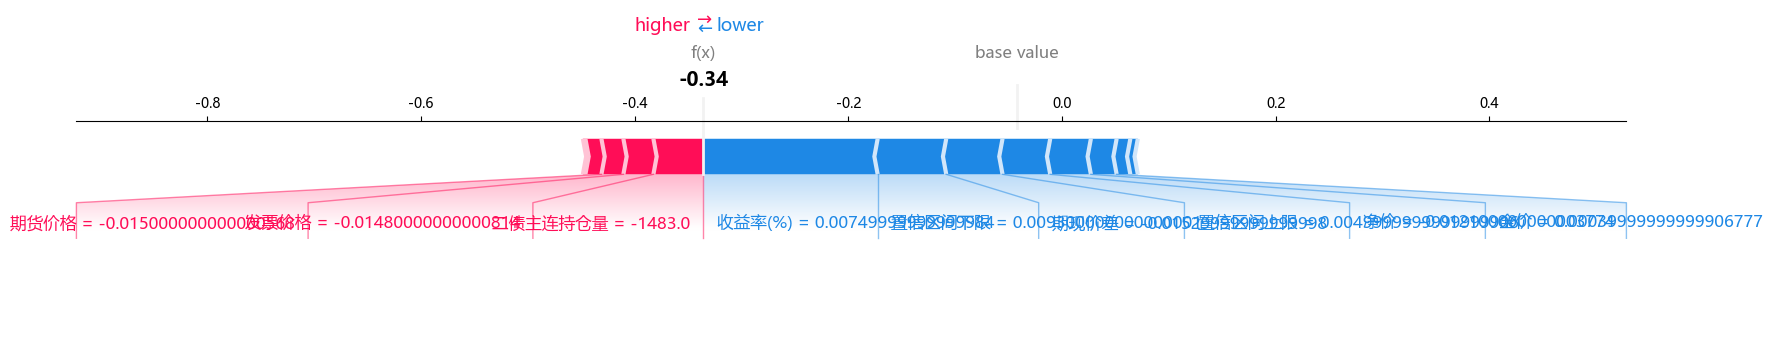


==== SHAP 图已保存 ====
 - xgb_shap_bar.png          （全局重要性-条形图）
 - xgb_shap_beeswarm.png     （全局重要性-蜂群图）
 - xgb_shap_depend_*.png     （Top特征依赖图）
 - xgb_shap_force_sample.png （单样本力图）


In [15]:
# ==== Matplotlib 中文字体配置（跨平台） ====
import matplotlib as mpl
from matplotlib import font_manager
import os, sys

def set_cn_font():
    # 常见中文字体候选（Windows / Mac / Linux）
    candidates = [
        "Microsoft YaHei", "SimHei", "SimSun",          # Win
        "PingFang SC", "Heiti SC", "STHeiti", "Songti SC",  # macOS
        "Noto Sans CJK SC", "WenQuanYi Zen Hei", "AR PL UMing CN"  # Linux
    ]
    # 如果你有自带字体文件（推荐），也可指定路径：
    # local_font_path = "/path/to/NotoSansCJKsc-Regular.otf"
    # if os.path.exists(local_font_path): candidates.insert(0, local_font_path)

    found = None
    installed = {f.name: f.fname for f in font_manager.fontManager.ttflist}
    for name in candidates:
        # 既支持名称也支持路径
        if os.path.isfile(name) and os.path.exists(name):
            found = name
            font_manager.fontManager.addfont(found)
            prop = mpl.font_manager.FontProperties(fname=found)
            mpl.rcParams['font.sans-serif'] = [prop.get_name()]
            break
        if name in installed:
            mpl.rcParams['font.sans-serif'] = [name]
            found = installed[name]
            break

    # 兼容负号显示
    mpl.rcParams['axes.unicode_minus'] = False

    if found is None:
        print("[WARN] 未找到系统中文字体，中文可能显示为方块。建议安装 Noto Sans CJK SC 或 Microsoft YaHei。")
    else:
        print(f"[INFO] 中文字体已启用: {mpl.rcParams['font.sans-serif'][0]}")

set_cn_font()

# ========== NEW (C): XGBoost + SHAP 可视化（全局/局部） ==========
import shap
import matplotlib.pyplot as plt

# 1) 选择用于解释的数据（建议用验证集，更贴近阈值选择）
X_explain = pd.DataFrame(X_val_fit_raw, columns=feat_cols)
y_explain = pd.Series(y_val_fit, name="label")

# 2) 计算 SHAP
explainer = shap.TreeExplainer(final_booster, feature_perturbation="interventional")
# 兼容新版/旧版 SHAP 返回形式
try:
    # 新接口：返回 Explanation 对象
    shap_exp = explainer(X_explain)
    shap_values = shap_exp.values            # (n_samples, n_features)
    base_value  = np.mean(shap_exp.base_values)
except Exception:
    # 旧接口：返回 ndarray
    shap_values = explainer.shap_values(X_explain)  # (n_samples, n_features)
    base_value  = explainer.expected_value if np.ndim(explainer.expected_value)==0 else np.mean(explainer.expected_value)

# 3) 全局：重要性条形图（平均绝对 SHAP）
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
plt.tight_layout(); plt.savefig("xgb_shap_bar.png", dpi=150); plt.close()

# 4) 全局：蜂群图（方向+分布）
plt.figure(figsize=(9, 6))
shap.summary_plot(shap_values, X_explain, show=False)
plt.tight_layout(); plt.savefig("xgb_shap_beeswarm.png", dpi=150); plt.close()

# 5) 单因子依赖图（前3个最重要特征）
#   —— 先根据平均|shap|排序挑TopK —— 
abs_mean = np.abs(shap_values).mean(axis=0)
rank_idx = np.argsort(abs_mean)[::-1]
topk = min(3, len(feat_cols))
for j in range(topk):
    feat = X_explain.columns[rank_idx[j]]
    plt.figure(figsize=(6, 5))
    shap.dependence_plot(feat, shap_values, X_explain, interaction_index=None, show=False)
    plt.tight_layout(); plt.savefig(f"xgb_shap_depend_{j+1}_{feat}.png", dpi=150); plt.close()

# 6) 单样本解释（力图，保存静态图）
i = 0  # 第 i 个样本
try:
    shap.initjs()  # 在 notebook 环境有用，脚本环境忽略
    force = shap.force_plot(base_value, shap_values[i, :], X_explain.iloc[i, :], matplotlib=True)
    plt.tight_layout(); plt.savefig("xgb_shap_force_sample.png", dpi=150); plt.close()
except Exception as e:
    print(f"[WARN] force_plot 生成失败：{e}")

print("\n==== SHAP 图已保存 ====")
print(" - xgb_shap_bar.png          （全局重要性-条形图）")
print(" - xgb_shap_beeswarm.png     （全局重要性-蜂群图）")
print(" - xgb_shap_depend_*.png     （Top特征依赖图）")
print(" - xgb_shap_force_sample.png （单样本力图）")

# 绘图

In [19]:
# ========== NEW (B): 累计价格损益（下一期结算，实盘口径，稳健对齐） ==========
# 规则：t 日生成仓位 pos_t（预测涨=+1，预测跌=-1），在 t→t+1 期间以
# Δbasis_{t+1} = basis_{t+1} - basis_t 结算：PnL_t = pos_t * Δbasis_{t+1}

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) 读取“未差分”的原始基差 ---
basis_excel_path = "基差.xls"  # 如路径不同请修改
basis_series = None
if os.path.exists(basis_excel_path):
    try:
        raw_basis = pd.read_excel(basis_excel_path).copy()
        # 自动识别日期列
        date_col = None
        for c in raw_basis.columns:
            if str(c).strip() in ["日期", "date", "Date", "交易日"]:
                date_col = c; break
        if date_col is not None:
            raw_basis[date_col] = pd.to_datetime(raw_basis[date_col], errors="coerce")
            raw_basis.set_index(date_col, inplace=True)
        else:
            # 若无日期列，假设与 df_clean 索引一致
            raw_basis.index = df_clean.index
        # 自动识别“基差”列（若列名不是“基差”，请手动指定）
        basis_col = None
        for c in raw_basis.columns:
            if "基差" in str(c):
                basis_col = c; break
        if basis_col is not None:
            basis_series = raw_basis[basis_col].astype(float).sort_index()
    except Exception as e:
        print(f"[WARN] 读取原始基差失败，将用差分累加近似重构。err={e}")

# --- 兜底：若未找到，则用 df_clean 中“基差差分”累加近似 ---
if basis_series is None:
    print("[WARN] 未找到未差分基差，将用 df_clean['基差(差分)'] 累加近似（可能与真实值有偏差）。")
    diff_basis_col = None
    for c in df_clean.columns:
        if "基差" in str(c):
            diff_basis_col = c; break
    if diff_basis_col is not None:
        basis_series = df_clean[diff_basis_col].astype(float).sort_index().cumsum()
    else:
        raise RuntimeError("未在 df_clean 中找到含“基差”的列，无法计算累计损益。")

# --- 2) 稳健对齐测试期索引与基差序列 ---
def _normalize_dtindex(idx) -> pd.DatetimeIndex:
    idx = pd.to_datetime(idx, errors="coerce")
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    return idx.normalize()  # 归一化到“日期”粒度

# 规范化基差索引
basis_series = basis_series.copy()
basis_series.index = _normalize_dtindex(basis_series.index)
basis_series = basis_series.sort_index()

# 取得“测试期日期索引”：若 df_te.index 不是日期或大多为 NaT，就用 df_clean 末尾 N_te 天
N_te = len(df_te)
test_index_raw = df_te.index
test_index_norm = _normalize_dtindex(test_index_raw)

if (not isinstance(test_index_raw, pd.DatetimeIndex)) or (pd.isna(test_index_norm).mean() > 0.5):
    idx_all = _normalize_dtindex(df_clean.sort_index().index)
    assert len(idx_all) >= N_te, "df_clean 行数少于测试集样本数，无法回推测试期日期。"
    test_index = idx_all[-N_te:]
else:
    test_index = test_index_norm

# 先做“精确对齐”
basis_test = basis_series.reindex(test_index)

# 若大量 NaN，使用 merge_asof 向前对齐（容忍 5 天）
if basis_test.isna().mean() > 0.5:
    lo, hi = test_index.min() - pd.Timedelta(days=10), test_index.max() + pd.Timedelta(days=10)
    basis_clip = basis_series.loc[(basis_series.index >= lo) & (basis_series.index <= hi)]
    # left: 测试期日期（强制列名为 'date'）
    left = pd.DataFrame({"date": pd.to_datetime(test_index)})
    # right: 基差（两列，强制命名为 'date' 和 'basis'）
    right = basis_clip.reset_index()
    right.columns = ["date", "basis"]
    right["date"] = pd.to_datetime(right["date"])
    aligned = pd.merge_asof(
        left.sort_values("date"),
        right.sort_values("date"),
        on="date",
        direction="backward",
        tolerance=pd.Timedelta(days=5)
    )
    basis_test = aligned.set_index("date")["basis"]

# 若仍全 NaN，再次回退到 df_clean 的差分累加近似并强制对齐
if basis_test.isna().all():
    print("[WARN] 基差文件与测试期日期完全不匹配；使用 df_clean['基差'] 的差分累加近似。")
    diff_basis_col = None
    for c in df_clean.columns:
        if "基差" in str(c):
            diff_basis_col = c; break
    assert diff_basis_col is not None, "回退失败：df_clean 中未找到‘基差’列。"
    approx_series = df_clean[diff_basis_col].astype(float).sort_index().cumsum()
    approx_series.index = _normalize_dtindex(approx_series.index)
    basis_test = approx_series.reindex(test_index).ffill().bfill()

# 最终再做一次前后填补，确保无 NaN
basis_test = basis_test.ffill().bfill()
assert not basis_test.isna().all(), "对齐失败：basis_test 仍为全 NaN，请检查基差文件日期或 df_clean 的索引。"

# --- 3) 生成仓位（预测明天涨→做多 +1；预测明天跌→做空 -1） ---
pred_te = (y_te_prob >= chosen_thr).astype(int)    # 长度 N_te
pos = np.where(pred_te == 1, 1, -1)                # +1/-1

# --- 4) 计算 Δbasis_{t+1} 并用 t 的仓位结算 ---
delta_next = basis_test.diff()                     # Δbasis_t
pnl = pos[:-1] * delta_next.values[1:]            # 长度 N_te - 1

# --- 5) 可选：加入换手成本 ---
fee_per_change = 0.0                               # 单位与“基差”一致；如有手续费/滑点在此设置
turnover = (pos[:-1] != pos[1:]).astype(int)       # 长度 N_te - 1
pnl = pnl - turnover * fee_per_change

# --- 6) 累计 & 保存结果 ---
cum_pnl = np.cumsum(pnl)
N = len(basis_test)
assert len(pred_te) == N, f"预测长度 {len(pred_te)} 与测试期 {N} 不一致"
assert len(pnl) == N-1 == len(turnover)

pnl_df = pd.DataFrame({
    "date":        basis_test.index[:-1],
    "basis_t":     basis_test.values[:-1],
    "basis_t1":    basis_test.values[1:],
    "delta_t1":    delta_next.values[1:],
    "prob":        np.asarray(y_te_prob)[:-1],
    "pred":        np.asarray(pred_te)[:-1],
    "pos":         np.asarray(pos)[:-1],
    "turnover":    turnover,
    "pnl":         pnl,
    "cum_pnl":     cum_pnl
}).set_index("date")

pnl_df.to_csv("pnl_detail.csv", encoding="utf-8-sig")

plt.figure(figsize=(10, 5))
plt.plot(pnl_df.index, pnl_df["cum_pnl"].values, linewidth=1.5)
plt.title("Result on test")
plt.xlabel("Date"); plt.ylabel("Cumulative P&L")
# 若曲线为常数（例如全 0），强制展开 y 轴
if np.nanmin(pnl_df["cum_pnl"].values) == np.nanmax(pnl_df["cum_pnl"].values):
    y0 = float(pnl_df["cum_pnl"].iloc[-1])
    plt.ylim(y0 - 1, y0 + 1)
plt.tight_layout(); plt.savefig("cum_pnl.png", dpi=150); plt.close()

print("\n==== Cumulative P&L (Test, next-day realized) ====")
print(f"Final Cum P&L: {float(cum_pnl[-1]) if len(cum_pnl)>0 else float('nan'):.6f}")
print("Saved: pnl_detail.csv, cum_pnl.png")

# （可选）快速自检
# print("[CHECK] test_index[:5]:", test_index[:5])
# print("[CHECK] basis_test.head():\n", basis_test.head())
# print("[CHECK] NaN % in basis_test:", float(basis_test.isna().mean())*100, "%")
# print("[CHECK] pnl_df.head():\n", pnl_df.head())


==== Cumulative P&L (Test, next-day realized) ====
Final Cum P&L: 3.176600
Saved: pnl_detail.csv, cum_pnl.png


In [4]:
import os
import pandas as pd

def merge_excels_by_first_col(folder_path, output_file="merged.xlsx"):
    files = [f for f in os.listdir(folder_path) if f.endswith(".xlsx") and not f.startswith("~")]
    if not files:
        print("未找到任何 .xlsx 文件")
        return

    dfs = []
    for f in files:
        path = os.path.join(folder_path, f)
        try:
            # 第一行作为列名，第一列作为索引
            df = pd.read_excel(path, header=0, index_col=0)
        except Exception as e:
            print(f"读取失败：{path}，原因：{e}")
            continue

        df.index = df.index.astype(str).str.strip()

        # 列名加前缀（保留原始列名，避免冲突）
        stem = os.path.splitext(f)[0]
        df.columns = [f"{stem}__{col}" for col in df.columns]

        dfs.append(df)

    if not dfs:
        print("没有成功读取的表格")
        return

    merged = pd.concat(dfs, axis=1, join="inner")

    merged.to_excel(output_file, index=True, header=True)
    print(f"合并完成，结果已保存到 {output_file}")
    print(f"合并后形状：{merged.shape}")

if __name__ == "__main__":
    merge_excels_by_first_col(r"D:\mycodelife\workshop\yinhe\factor_918")



合并完成，结果已保存到 merged.xlsx
合并后形状：(3183, 508)
